In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import scipy.io
import pandas as pd
import sys
sys.path.insert(0,"C:/Users/Janine/.local/share/emcee-master")
import emcee as mc
import corner
import tqdm
import warnings

from trig_fund import *
from dambreak import dambreak
from syrup_prop import Visc

# set default plotting parameters
plt.rc('font', size=22) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 4.0 #set default line width to 2.0 (from 1.0)

# filter warnings regularly ecountered in the model
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in power")
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="invalid value encountered in less")
warnings.filterwarnings("ignore", message="overflow encountered in true_divide")

## Janine Birnbaum 

Created June 28, 2019

Last update July 30, 2019

Read flow data from video files and still images and compare with model.

## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

## Comparison to experimental data

Import video of experimental data and find the flow front through time:

In [4]:
# Change these parameters

startFrame = 0
endFrame = 750

# RGB channel and threshold for front picking
thresh = 150
channel = 2 #0 = Red, 1 = Green, 2 = Blue

# Video file
filedir = r'C:\Users\Janine\Documents\Columbia Research\3-phase_flow\Lab_Photos\77sugar\Particle-syrup validation' # path to file
filename = r'\MVI_0680_edit.mov'# file name

# manually set starting location, line for analysis
# black in next figure
x0 = 468 # pixels
yline = 1200

# crop image
top = 900
bottom = 1500

title_str = 'Validation'

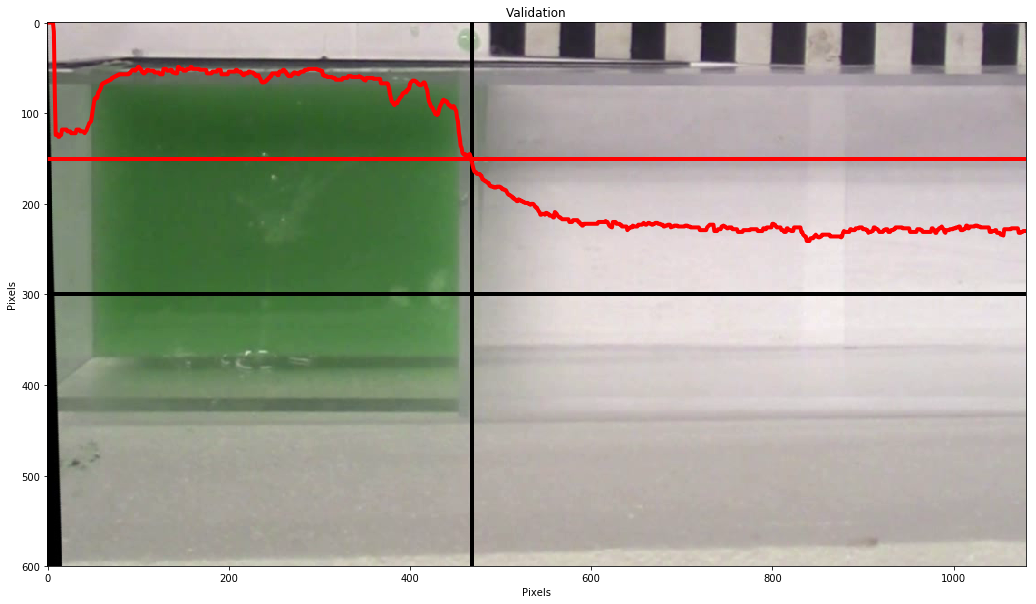

In [5]:
y2 = bottom - top - 1

# read first frame from video
cap = cv2.VideoCapture(filedir +  filename)
fps = cap.get(cv2.CAP_PROP_FPS)

ret, frame = cap.read()
if ret:
    pic = np.flip(frame,2)
    pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
cap.release()

# plot cropped image, profile for analysis
# x0 and yline in black
# threshold and profile along yline in red
fig,ax = plt.subplots(figsize=(20,10))
ax.imshow(pic[top:bottom,:,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([0, pic.shape[1]-1], [yline-top, yline-top], 'k')
ax.plot(pic[yline,:,channel], 'r')
ax.plot([0, pic.shape[1]-1], [thresh, thresh], 'r')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title(title_str);

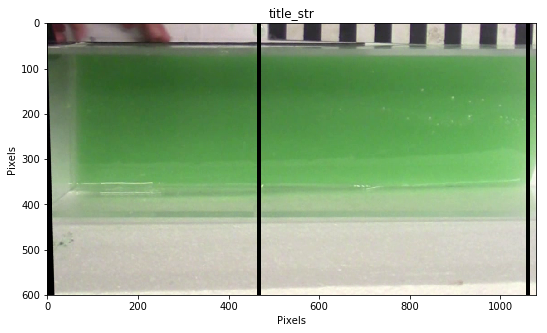

In [6]:
currentFrame = 0

y2 = bottom - top - 1

# read video from start to end frame
cap = cv2.VideoCapture(filedir +  filename)
fps = cap.get(cv2.CAP_PROP_FPS)
pos = np.zeros(endFrame-startFrame)

while(currentFrame<endFrame):
    ret, frame = cap.read()
    if currentFrame >= startFrame:
        if ret:
            pic = np.flip(frame,2)
            pic = np.transpose(pic,axes=(1,0,2)) #turn on for flow from top to bottom
            pos[currentFrame - startFrame] = np.max(np.where(pic[yline,:,channel]<thresh))
    
    currentFrame += 1
    
cap.release()

# plot final frame
fig,ax = plt.subplots(figsize=(15,5))
ax.imshow(pic[top:bottom,:,:])
ax.plot([x0, x0], [0, y2], 'k')
ax.plot([pos[-1], pos[-1]], [0, y2], 'k')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('title_str');

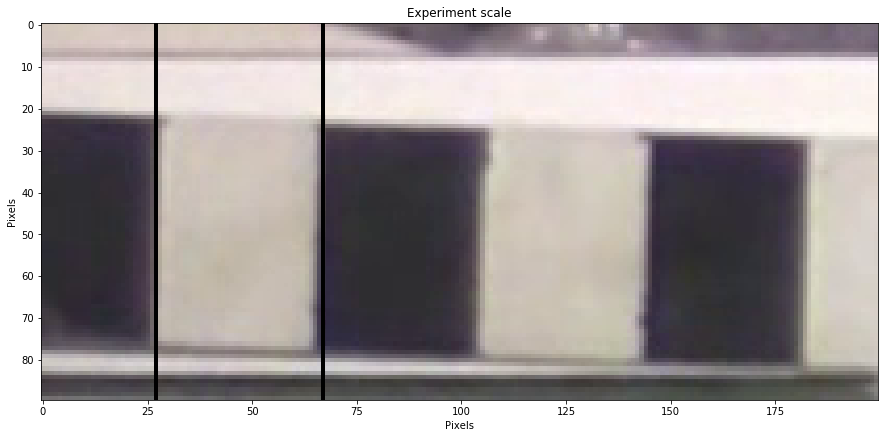

In [7]:
# Calculate image scale
# Crop image
top2 = 860
bottom2 = 950
left2 = 500
right2 = 700

# Plot
fig,ax = plt.subplots(figsize=(15,20))
ax.imshow(pic[top2:bottom2,left2:right2,:])

# Set to align with one 2cm segment on scale
lft = 27
rgt = 67

# Plot
ax.plot([lft, lft], [0, bottom2-top2-1], 'k')
ax.plot([rgt, rgt], [0, bottom2-top2-1], 'k')

# Determine scaling factors
W = 0.02 # m
k = W/(rgt-lft) # m/pixel
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
ax.set_title('Experiment scale');

In [29]:
# scale time and front position
pos_scaled = (pos-x0)*k
pos_scaled[pos_scaled<0] = 0
t_scaled = np.arange((pos_scaled).size)/fps

t0 = 2.73 # Time of dam release [sec]
tf = 26 # End time [sec]

x_pos = pos_scaled[(t_scaled>t0) & (t_scaled<tf)]
t_pos = t_scaled[(t_scaled>t0) & (t_scaled<tf)]-t0

# plot scaled front advance
fig,ax = plt.subplots(figsize=(15,3))
ax.plot(t_pos, x_pos)
ax.plot([0, tf - t0], [0, 0], 'r--')
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Distance (m)')
ax.set_title('Experiment flow advance');

NameError: name 'pos' is not defined

In [34]:
samples = pd.read_hdf('Validation.h5',key='s').values
meta = pd.read_hdf('Validation.h5',key='meta')
H = meta.H[0]
K_fluid = meta.K_fluid[0]
L = meta.L[0]
rho = meta.Rho[0]
df = pd.read_hdf('Validation.h5',key='df')
t_pos = df.Time.values
x_pos = df.X_pos.values

K_true = 9.71201941; n_true = 0.97902562


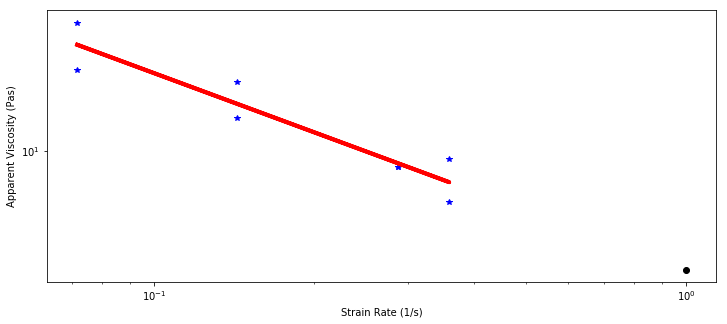

In [16]:
# Viscometer Data
spindle_d = 1.85 #(cm)
beaker_d = 3.2 #(cm)
kNy = 2*np.pi*spindle_d/(60*(beaker_d - spindle_d))

RPM = np.array([0.5, 1, 2, 2.5, 2.5, 2, 1, 0.5])
gamma = kNy*RPM
Pas = np.array([10.32, 10.08, 9.96, 9.876, 9.9792, 9.96, 10.17, 10.2])

m,b = np.polyfit(np.log(gamma), np.log(Pas), 1)
K_true = np.exp(b)
n_true = m + 1

print('K_true = ' + np.array2string(K_true) + '; n_true = ' + np.array2string(n_true))
tauy_true = 0

fig,ax = plt.subplots(figsize=(12,5))
ax.loglog(gamma,Pas,'b*')
ax.loglog(gamma, K_true*gamma**(n_true-1) + tauy_true/gamma,'r')
ax.loglog(1, K_true*1**(n_true-1) + tauy_true,'ko')
ax.set_xlabel('Strain Rate (1/s)')
ax.set_ylabel('Apparent Viscosity (Pas)');

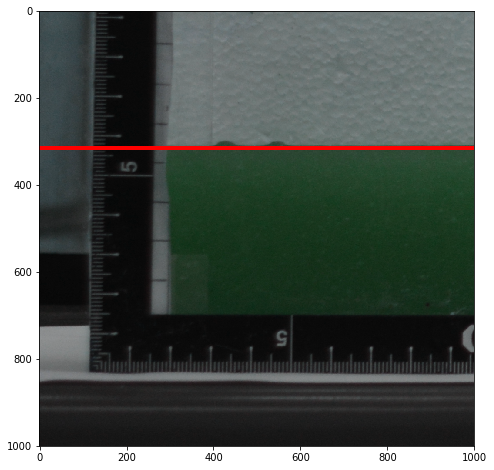

In [26]:
# Change these parameters
filedir = r'C:\Users\Janine\Documents\Columbia Research\3-phase_flow\Lab_Photos\77sugar\Particle-syrup validation\566D5200'# path to file
filename = '\DSC_0097.JPG'# file name of side photo

# Crop image
top = 2000
bottom = 3000

left = 500
right = 1500

base = 1.27 # channel base thickness in cm

# Load and plot
img = cv2.imread(filedir + filename) 

fig, ax = plt.subplots(figsize=(12,8))
plt.imshow(img[top:bottom, left:right])

# Find top of reservoir
height = 315
plt.plot([0, right-left-1], [height, height],'r')

# Reservoir depth
H = (5.7 - base)/100 # in m

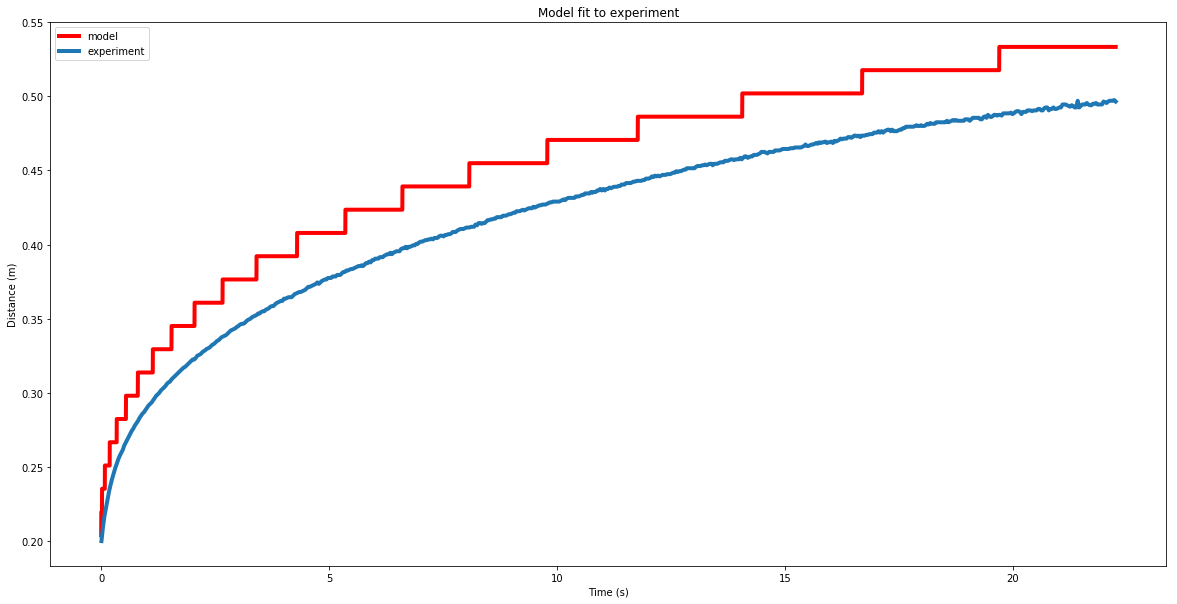

In [30]:
# Simulate video
L = 0.2  # reservoir length in m
K_fluid = 9.8 # consistency in Pas
rho = 1540 # density in kg/m^3
g = 9.81   # gravitational acceleration m/s^2
ts = t_pos[-1] # time in s
theta = 0 # slope in degrees

# Discretize domain 
m = 50
x = np.linspace(0, 4*L, m+2)
dx = x[1] - x[0]

# Number of time steps
i = 25000

# Initial condition
h0 = np.zeros_like(x)
h0[x<L] = H

K_true = 10
n_true = 0.95
tauy_true = 0

# Solve
h, t = dambreak(x, h0, theta, rho, K_true, tauy_true, n_true, g, ts, i)

# Initialize front location
X = np.zeros_like(t)

threshold = 0.0001
for j in np.arange(h.shape[0]):
    X[j] = x[np.max(np.nonzero(h[j,:]>threshold)) + 1] # find node with h>threshold


# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t,X,'r-',label='model');
ax.plot(t_pos,x_pos+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [12]:
# Save data to file

# Save data to file

df = pd.DataFrame({'X_pos':x_pos, 'Time':t_pos})
meta = pd.DataFrame({'H':H, 'L':L, 'K_fluid':K_fluid, 'Rho':rho, 'Slope':theta, 'Title':title_str, 'Temp':25,
                    'Phi_solid':0.10, 'Phi_gas':0, 'Particle':'Glass'}, index=[0])

df.to_hdf(title_str + '.h5', key='df', mode='w')
meta.to_hdf(title_str + '.h5', key='meta', mode='a')

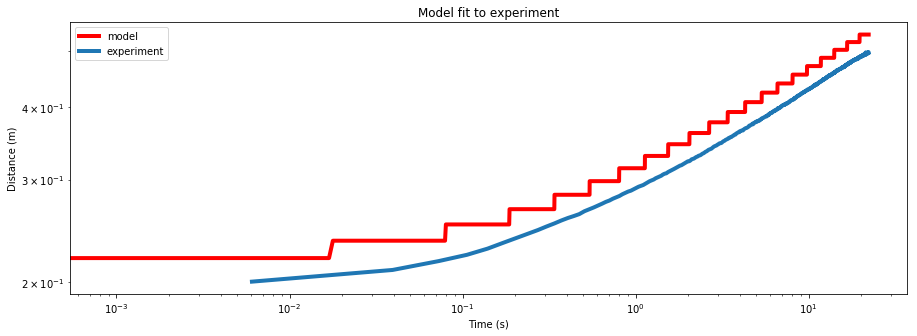

In [31]:
# Plot data and fitting parameters

fig,ax = plt.subplots(figsize=(15,5))
ax.loglog(t,X,'r-',label='model');
ax.loglog(t_pos,x_pos+L,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [74]:
# Setup model for MCMC

def lnlike(mu, x, y, yerr):
    K, tauy, n = mu
    h, t = dambreak(x_grid, h0, 0, 1540, K, tauy, n, 9.81, t_pos[-1], 50*t_pos.size)
    X = np.zeros_like(t_pos)
    t_match = np.zeros_like(t_pos)

    threshold = 0.0001
    for j in np.arange(t_pos.shape[0]):
        X[j] = x_grid[np.max(np.nonzero(h[j*50,:]>threshold)) + 1] # find node with h>threshold
        t_match[j] = t[j*50]
    
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])
    
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*yerr**2)))

In [93]:
# Initial guesses for MCMC
K_init = K_true
K_min = 6
K_max = 15

tauy_init = tauy_true
tauy_min = 0
tauy_max = 1

n_init = n_true
n_min = 0.8
n_max = 3

init_pos = [K_init, tauy_init, n_init]

# load data to MCMC
x = t_pos
y = x_pos + L

# Define model resolution for MCMC
x_grid = np.linspace(0,0.75,52)
dx = x_grid[1] - x_grid[0]
yerr = dx
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

In [94]:
# Uniform prior distribution
def lnprior(mu):
    K, tauy, n = mu
    if K_min < K < K_max and tauy_min < tauy < tauy_max and n_min < n < n_max:
        return 0.0
    return -np.inf

def lnprob(mu, x, y, yerr):
    lp = lnprior(mu)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(mu, x, y, yerr)

In [95]:
# Create walkers
ndim, nwalkers = 3, 6
mu_pos = [init_pos + [1e-1, 1e-2, 1e-2]*np.random.randn(ndim) for i in range(nwalkers)]

In [96]:
# Run MCMC
steps = 150
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(mu_pos, steps, progress=True);

  0%|                                                  | 0/150 [00:00<?, ?it/s]C:/Users/Janine/.local/share/emcee-master\emcee\moves\red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████████████████████████████████| 150/150 [2:05:29<00:00, 53.58s/it]


K = 13.7, tau_y = 0.09, n = 1.04


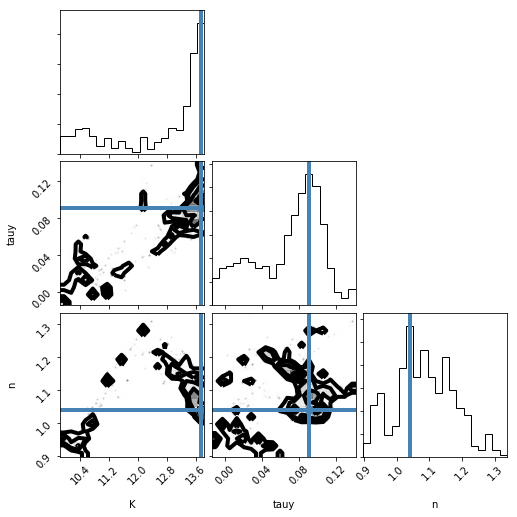

In [97]:
# Inspect MCMC results
s = 0 # ignore initial samples
samples = sampler.chain[:, s:, :].reshape((-1, ndim))

K_fit = samples[:,0]; tauy_fit = samples[:,1]; n_fit = samples[:,2]

# Find mode of each posterior distribution
N, bin_edges = np.histogram(K_fit, bins=20)
K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(tauy_fit, bins=20)
tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(n_fit, bins=20)
n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

# plot
fig = corner.corner(samples, labels=["K", "tauy", "n"],
                   truths=[K_post, tauy_post, n_post])
print('K = ' + np.array2string(K_post, precision=1) + 
      ', tau_y = ' + np.array2string(tauy_post, precision=2) + 
      ', n = ' + np.array2string(n_post, precision=2))

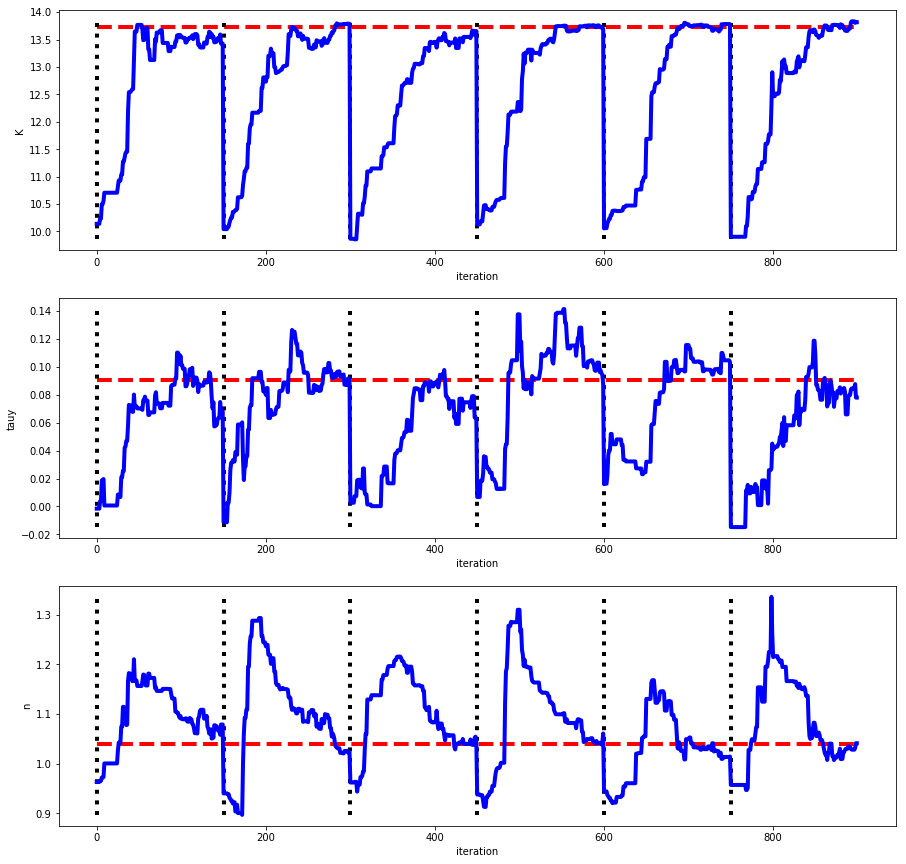

In [98]:
# inspect runs
s = 0
samples_full = sampler.chain[:, s:, :].reshape((-1, ndim))

fig,ax = plt.subplots(nrows=3, figsize=(15,15))
ax[0].plot(samples_full[:,0],'b-')
ax[0].hlines(K_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[0].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,0]),np.max(samples_full[:,0]),colors='k',linestyles='dotted')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('K')
ax[1].plot(samples_full[:,1],'b-')
ax[1].hlines(tauy_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[1].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,1]),np.max(samples_full[:,1]),colors='k',linestyles='dotted')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('tauy')
ax[2].plot(samples_full[:,2],'b-')
ax[2].hlines(n_post, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[2].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,2]),np.max(samples_full[:,2]),colors='k',linestyles='dotted')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('n');

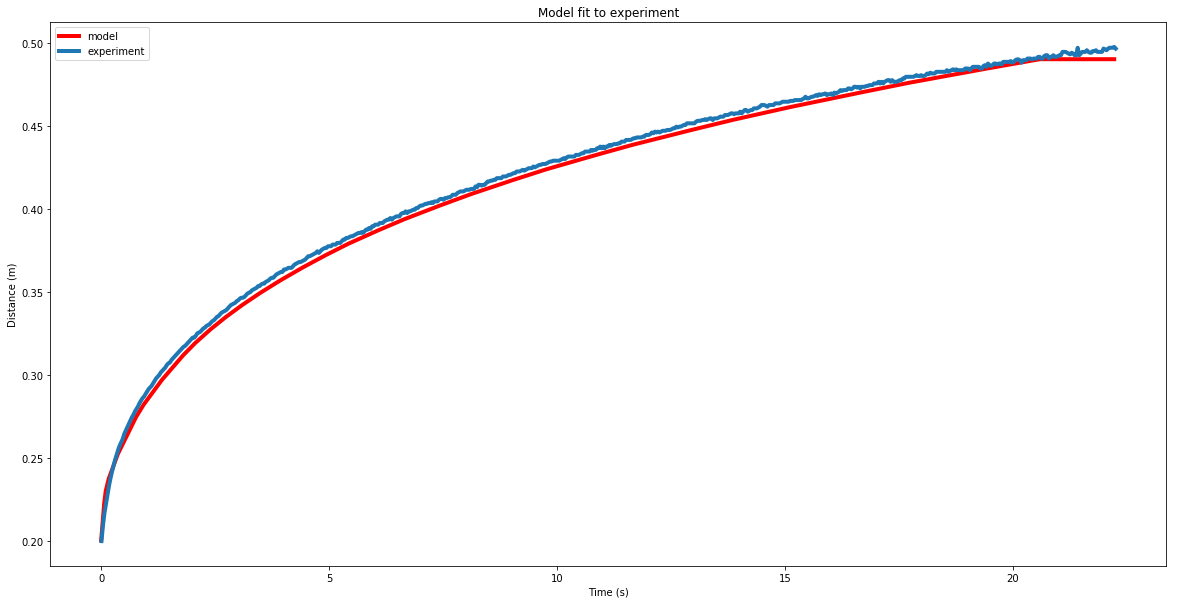

In [99]:
x_grid = np.linspace(0,0.75,102)
dx = x_grid[1] - x_grid[0]
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

h, t = dambreak(x_grid, h0, 0, rho, K_post, tauy_post, n_post, 9.81, t_pos[-1], 200*t_pos.size)
X = np.zeros_like(t_pos)

threshold = 0.0001
for j in np.arange(t_pos.shape[0]):
    X[j] = x_grid[np.max(np.nonzero(h[j*200,:]>threshold)) + 1] # find node with h>threshold
ind = np.nonzero(X[1:] - X[:-1])[0]
x_interp = np.interp(t_match,t_match[ind],X[ind])

# Plot front advance
fig,ax = plt.subplots(figsize=(20,10))

ax.plot(t_match,x_interp,'r-',label='model');
ax.plot(x,y,label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.set_title('Model fit to experiment')
ax.legend();

In [100]:
s = 0 # ignore initial samples
samples = sampler.chain[:, s:, :].reshape((-1, ndim))
K_fit = samples[:,0]; tauy_fit = samples[:,1]; n_fit = samples[:,2]


meta['K_post'] = K_post
meta['K_r'] = K_post/K_fluid
meta['tauy_post'] = tauy_post
meta['n_post'] = n_post

meta.to_hdf('Validation' + '.h5', key='meta', mode='a')

samples = pd.DataFrame({'K':K_fit, 'tauy':tauy_fit, 'n':n_fit})
samples.to_hdf('Validation' + '.h5', key='s', mode='a')
